/Users/kootsoop/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


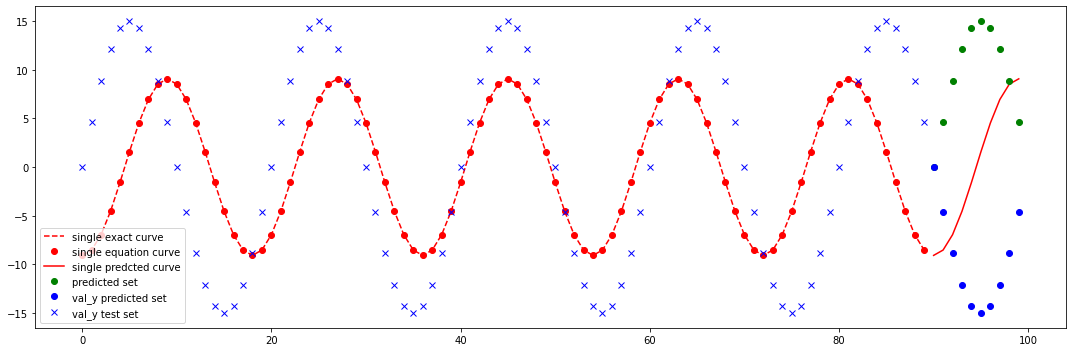

In [19]:
from numpy import pi, sin, arange, mean, abs as absolute, where, nanmin, nanmax, angle, arctan2, sqrt, array, random, append, transpose
from matplotlib import pyplot as plt
from scipy import fftpack
import pandas as pd


class GenericSignals():
    
    def __init__(self, time_vec):
        self.time_vec = time_vec
    
    def createSingleSignal(self, w=.2, a=10, ph=0):
        # x is x axis time vector, w is wavelength, a is amplitude, ph is phase
        x = self.time_vec
        return a * sin((2 * pi / w * x) + ph)
    
    def combineNSignals(self, *args):
        return sum(args)
    
    def getFrequencies(self, signal, dt):
        sig_fft = fftpack.fft(signal)
        sample_freq = fftpack.fftfreq(len(signal), d=dt)
        power = absolute(sig_fft) * dt
        return power, sample_freq
    
    def findPeakFrequencies(self, sample_freq, power, n=1):
        #n is number of frequencies to get
        pos_mask = where(sample_freq > 0)
        freqs = sample_freq[pos_mask]
        pos_power = power[pos_mask]
        pos_power_sorted = sorted(pos_power)
        dominent = pos_power_sorted[-n:]
        # need to reorganize dominent to have proper sorting now
        dominant_freq_indices = []
        peak_freqs = []
        for i in range(len(dominent)):
            dominant_freq_indices.append(where(pos_power == dominent[i])[0][0])
            peak_freqs.append(freqs[dominant_freq_indices[i]])
        return peak_freqs
    
    def createIndividualSignalsForEachFreq(self, signal, sample_freq):
        filtered_signals = []
        for i in range(len(sample_freq)):
            high_freq_fft = fftpack.fft(signal)
            high_freq_fft[absolute(sample_freq) < nanmin(sample_freq[i])] = 0
            high_freq_fft[absolute(sample_freq) > nanmax(sample_freq[i])] = 0
            filtered_sig = fftpack.ifft(high_freq_fft)
            filtered_sig -= mean(filtered_sig)
            filtered_signals.append(filtered_sig)
        return filtered_signals
    
    def getPhaseAmplitudeWavelength(self, signal, freq, sample_freq):
        # if statement resolves a divide by 0 runtime warning
        if freq == 0:
            fixed_freq = .0000000000001
            wavelength = 1 / fixed_freq 
        else:
            wavelength = 1 / freq 
        sig_size = len(signal)
        sig_fft = fftpack.fft(signal)
        sample_index = where(sample_freq==freq)
        phase = (arctan2(sig_fft[sample_index].imag, sig_fft[sample_index].real))[0]
        ph = phase + pi/2
        amp = (sqrt((sig_fft[sample_index].real * sig_fft[sample_index].real) + (sig_fft[sample_index].imag * sig_fft[sample_index].imag)) / (sig_size / 2))[0]
        return ph, amp, wavelength
    
    def getAllPhaseAmplitudeWavelengths(self, all_signals, sample_freq):
        wavelengths = []
        phases = []
        amplitudes = []
        i = 0
        for individual_signal in all_signals:
            phase, amplitude, wavelength = self.getPhaseAmplitudeWavelength(individual_signal, sample_freq[i], sample_freq)
            i += 1
            wavelengths.append(wavelength)
            phases.append(phase)
            amplitudes.append(amplitude)
        return wavelengths, phases, amplitudes

    def eqn(self, signal, wavelength, time_vec, phase, amp):
        signals_mean = absolute(mean(signal))
        return (amp * sin((2 * pi / wavelength * time_vec) + phase)) + signals_mean
    
    def getEquations(self, wavelength, time_vec, ph, amp):
        equations = []
        for i in range(len(wavelength)):
            equation = (amp[i] * sin((2 * pi / wavelength[i] * time_vec) + ph[i]))
            equations.append(equation)
        return equations
    
    def predictFuture(self, new_time_vec, equations, wavelength, ph, amp):
        # addidtional_step = new_time_vec[-1] + 1
        # new_time_vec = append(new_time_vec, addidtional_step)[1:]
        pred = []
        for i in range(len(equations)):
            pred.append(self.eqn(equations[i], wavelength[i], new_time_vec, ph[i], amp[i]))
        return pred
    
class PreProcessData():
    
    def __init__(self, data):
        self.data = data
        
    # separate data into test and validate sets for x and y and for each interval
    def createTestValidateSets(self, data, interval_to_predict):
        # interval to predict must be less than 1/3 size od dataset
        try:
            data_x = data[0]
            data_y = data[1]
            if interval_to_predict * 3 >= len(data_x):
                interval_to_predict = 1
            if interval_to_predict == 0:
                test_x = data_x
                val_x = []
                test_y = data_y
                val_y = []
            else:
                test_x = data_x[:-interval_to_predict]
                val_x = data_x[-interval_to_predict:]
                test_y = data_y[:-interval_to_predict]
                val_y = data_y[-interval_to_predict:]
            return test_x, test_y, val_x, val_y
        except Exception as e:
            return 'PreProcessData.createTestValidateSets failed: ' + e
    
if __name__ == "__main__":
    
    dt = 1
    time_vec = arange(0, 100, dt)
    genSig = GenericSignals(time_vec)
    testing_signal = genSig.createSingleSignal(w=20, a=15, ph=0)
    testing_signal2 = genSig.createSingleSignal(w=10, a=15, ph=0)
    test_signal = testing_signal
    predict_interval = 10
    preProcessedData = PreProcessData(test_signal)
    test_x, test_y, val_x, val_y = preProcessedData.createTestValidateSets([time_vec, test_signal], predict_interval)
    power, sample_freq = genSig.getFrequencies(test_y, dt)
    individual_signals = genSig.createIndividualSignalsForEachFreq(test_y, sample_freq)
    test_index = 5
    fft = fftpack.fft(individual_signals[test_index])
    fft_phase = arctan2(fft[test_index].imag, fft[test_index].real)

    wavelengths, phases, amplitudes = genSig.getAllPhaseAmplitudeWavelengths(individual_signals, sample_freq)
    equations = genSig.getEquations(wavelengths, test_x, phases, amplitudes)
    index2 = int(len(test_x) / 2 - 1)
    all_equations = sum(equations[1:index2])
    y_shift = mean(test_y) - mean(all_equations)
    all_equations += y_shift
    predicted_curves = genSig.predictFuture(val_x, equations, wavelengths, phases, amplitudes)
    total_pred = sum(predicted_curves)
    total_pred += y_shift
    fig, axs = plt.subplots(1, 1, figsize=(15,5))
    axs.plot(test_x, individual_signals[test_index], 'r--', label='single exact curve')
    axs.plot(test_x, equations[test_index], 'ro', label='single equation curve')
    axs.plot(val_x, predicted_curves[test_index], 'r', label='single predcted curve')
    # axs.plot(time_vec, test_signal, 'b--', label='test set')
    # axs.plot(test_x, all_equations, 'bo', label='ALL equations set')
    # axs.plot(val_x, val_y, 'g--', label='val set')
    # for i in range(1, 8):
    #     axs.plot(val_x, predicted_curves[i], label=f'pred set: {i}')
    # axs.plot(val_x, sum(predicted_curves[1:3]), label='pred curves')
    axs.plot(val_x, total_pred, 'go', label='predicted set')
    axs.plot(val_x, val_y, 'bo', label='val_y predicted set')
    axs.plot(test_x, test_y, 'bx', label='val_y test set')
    axs.legend()
    fig.tight_layout()
    plt.show() 

In [20]:
print(wavelengths)

[10000000000000.0, 90.0, 45.0, 30.0, 22.5, 18.0, 15.0, 12.857142857142858, 11.25, 10.0, 9.0, 8.181818181818182, 7.5, 6.9230769230769225, 6.428571428571429, 5.999999999999999, 5.625, 5.294117647058823, 5.0, 4.7368421052631575, 4.5, 4.285714285714286, 4.090909090909091, 3.913043478260869, 3.75, 3.5999999999999996, 3.4615384615384612, 3.3333333333333335, 3.2142857142857144, 3.103448275862069, 2.9999999999999996, 2.903225806451613, 2.8125, 2.727272727272727, 2.6470588235294117, 2.571428571428571, 2.5, 2.432432432432432, 2.3684210526315788, 2.3076923076923075, 2.25, 2.1951219512195124, 2.142857142857143, 2.093023255813953, 2.0454545454545454, -2.0, -2.0454545454545454, -2.093023255813953, -2.142857142857143, -2.1951219512195124, -2.25, -2.3076923076923075, -2.3684210526315788, -2.432432432432432, -2.5, -2.571428571428571, -2.6470588235294117, -2.727272727272727, -2.8125, -2.903225806451613, -2.9999999999999996, -3.103448275862069, -3.2142857142857144, -3.3333333333333335, -3.461538461538461